In [ ]:
import os
import time
import torch
import numpy as np
from torch.utils import data
from loader.real_data_loader import real_data_loader
from utils.data import *
from models.unet import Unet
from models.utils import *
from models.discriminator import Basic_D
from utils.train import *
from IPython.display import clear_output
from utils.loss import *
from models.dc_blocks import *

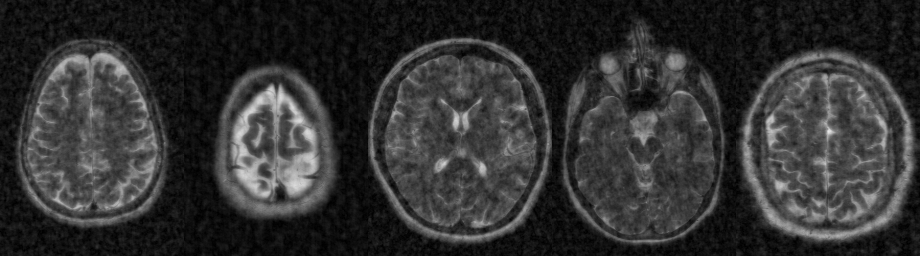

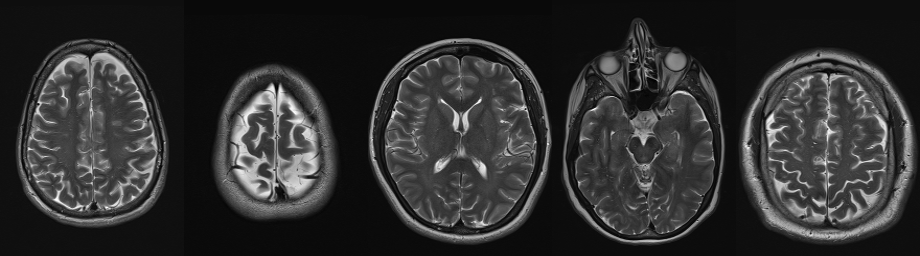

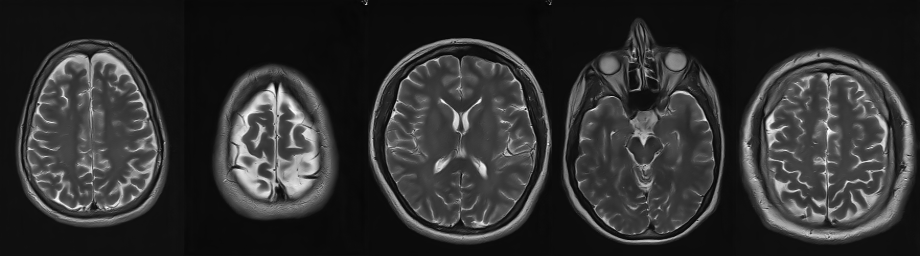

epochs: [46/150], batchs: [500/551], Loss_D_real: 0.000641, Loss_D_fake: 0.001164Loss_G: 7.459267, loss_L1: 0.007808, loss_dc: 0.000120, time: 17078s


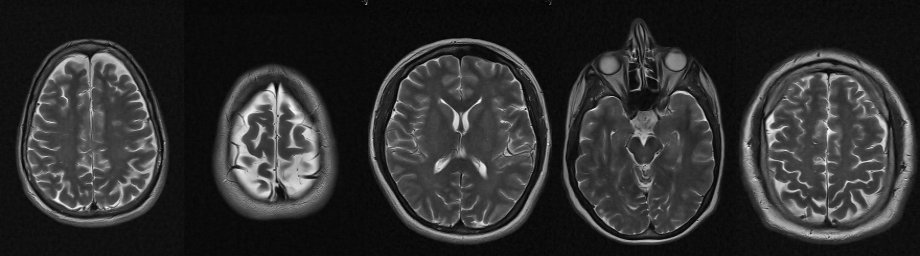

In [ ]:
if __name__ == '__main__':

    os.environ["CUDA_VISIBLE_DEVICES"] = '0'
    lrG = lrD = 2e-4
    niter = 150
    batch_size = 16
    epoch = 0
    gen_iterations = 0
    errL1_sum = errG_sum = errD_real_sum = errD_fake_sum = errdc_sum = 0
    
    display_iters = 10
    lambda_l1 = 1000
    lambda_dll2 = 0.001
    lambda_dc = 1000

    t0 = time.time()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    dataLoader = real_data_loader(split='train')
    trainLoader = data.DataLoader(dataLoader, batch_size=batch_size, shuffle=True)

    netG = Unet(input_channels=2, output_channels=2, num_filters=[2**i for i in range(5, 10)])
    netD = Basic_D(input_channels=2, output_channels=2, num_filters=[32, 64, 128, 256])
    netG.to(device)
    netD.to(device)

    optimizerD, optimizerG = get_optimizers(netG, netD, lrG, lrD)
    print(netG)
    
    while epoch < niter: 
        
        epoch += 1
        for idx, (inputs, targets, csms, masks) in enumerate(trainLoader):
            
            if gen_iterations%display_iters == 0:
                if gen_iterations%(5*display_iters) == 0:           
                    clear_output()
                
                sampling = True
                inputs_show, idxs = showImage(inputs, sampling=sampling)
                
                sampling = False
                targets_show, idxs = showImage(targets, idxs=idxs, sampling=sampling)

                inputs = inputs.to(device)
                targets = targets.to(device)
                csms = csms.to(device)
                masks = masks.to(device)
                
                outputs = netG(inputs)
                outputs_np = np.squeeze(np.asarray(outputs.cpu().detach()))
                outputs_show, idxs = showImage(outputs_np, idxs=idxs, sampling=sampling)

                print('epochs: [%d/%d], batchs: [%d/%d], Loss_D_real: %f, Loss_D_fake: %f' \
                      'Loss_G: %f, loss_L1: %f, loss_dc: %f, time: %ds'
                % (epoch, niter, idx, 8800//batch_size+1, errD_real_sum/display_iters, errD_fake_sum/display_iters,
                   errG_sum/display_iters, errL1_sum/display_iters, errdc_sum/display_iters, time.time()-t0))

                errL1_sum = errG_sum = errD_real_sum = errD_fake_sum = errdc_sum = 0
                
                A = Back_forward(csms, masks, lambda_dll2)
                rhs = lambda_dll2*outputs + inputs
                dc_layer = DC_layer(A, rhs)
                tmp_images = dc_layer.CG_iter()
                tmp_images_np = np.squeeze(np.asarray(tmp_images.cpu().detach()))
                tmp_show, idxs = showImage(tmp_images_np, idxs=idxs, sampling=sampling)
                
            inputs = inputs.to(device)
            targets = targets.to(device)
            csms = csms.to(device)
            masks = masks.to(device)

            errD_real, errD_fake = netD_train(inputs, targets, netD, netG, optimizerD)
            errD_real_sum += errD_real
            errD_fake_sum += errD_fake

            AtA = Back_forward(csms, masks, lambda_dll2).AtA
            errG, errL1, errdc = netG_train(inputs, targets, AtA, \
                netD, netG, optimizerG, lambda_l1, lambda_dc)
            errG_sum += errG
            errL1_sum += errL1
            errdc_sum += errdc

            gen_iterations += 1